In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import unicodedata
import re

In [3]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [0]:
df = pd.read_csv(path_to_file, sep='\t', header=None)
df.columns = ['eng', 'spa']

In [5]:
df.shape

(118964, 2)

In [6]:
df.sample(10)

,eng,spa
57535,I'm glad you like my present.,Me alegro de que te haya gustado mi regalo.
15811,Does he have money?,¿Tiene dinero?
114849,A high degree of specialization is required in...,Un alto grado de especialización es requerido ...
76435,I think Tom knows what he's doing.,Creo que Tom sabe lo que está haciendo.
104960,Does this letter have to be written in English?,¿Esta carta debe ser escrita en inglés?
75201,You may stay here if you want to.,Puede quedarse si lo desea.
2300,Tom's upset.,Tom está disgustado.
72805,I really do want Tom to be happy.,Realmente quiero que Tom sea feliz.
94904,I bought a leather frame for the picture.,Compré un marco de cuero para el retrato.
90135,He ate rice twice a day for many years.,Él ha comido arroz dos veces al día durante mu...


In [0]:
def unicode_to_ascii(sentence):
  return ''.join(word for word in unicodedata.normalize('NFD', sentence) if unicodedata.category(word) != 'Mn')

In [8]:
unicodedata.category('¿')

'Po'

In [0]:
def preprocess_text(sentence):
  sentence = unicode_to_ascii(sentence)
  sentence = re.sub(r'([!.,?¿])', r' \1 ', sentence) # \1 means the first charater.. "<space> <first char> <space>"
  sentence = re.sub(r'[" "]+', ' ', sentence)
  sentence = re.sub(r'[^a-zA-Z!.,?¿]+', ' ', sentence)
  sentence = sentence.rstrip().strip()
  sentence = '<start> '+sentence+' <end>'
  return sentence

In [10]:
preprocess_text('heoool.')

'<start> heoool . <end>'

In [0]:
df['eng'] = df['eng'].apply(preprocess_text)
df['spa'] = df['spa'].apply(preprocess_text)

In [12]:
df.head()

,eng,spa
0,<start> Go . <end>,<start> Ve . <end>
1,<start> Go . <end>,<start> Vete . <end>
2,<start> Go . <end>,<start> Vaya . <end>
3,<start> Go . <end>,<start> Vayase . <end>
4,<start> Hi . <end>,<start> Hola . <end>


In [0]:
eng_data = df['eng'].tolist()
spa_data = df['spa'].tolist()

In [0]:
lang_token = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<UNK>')

In [0]:
def tokenize_lang(language_data):
  lang_token = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<UNK>')
  lang_token.fit_on_texts(language_data)
  lang_sequence = lang_token.texts_to_sequences(language_data)
  return lang_sequence, lang_token

In [0]:
eng_sequence, eng_token = tokenize_lang(eng_data)
spa_sequence, spa_token = tokenize_lang(spa_data)

In [17]:
def lang_maxlength(lang_sequence):
  result = max([len(seq) for seq in lang_sequence])
  return result

print(lang_maxlength(eng_sequence))

51


In [18]:
eng_maxlen = lang_maxlength(eng_sequence)
spa_maxlen = lang_maxlength(spa_sequence)

def pad_sequence(lang_seq, max_len):
  return tf.keras.preprocessing.sequence.pad_sequences(lang_seq, maxlen=max_len, padding='post')

eng_sequence = pad_sequence(eng_sequence, eng_maxlen)
spa_sequence = pad_sequence(spa_sequence, spa_maxlen)

print(f'eng : {eng_sequence.shape}, eng_max_length: {eng_maxlen}, Token: eng_token')
print(f'eng : {spa_sequence.shape}, eng_max_length: {spa_maxlen}, Token: spa_token')

eng : (118964, 51), eng_max_length: 51, Token: eng_token
eng : (118964, 53), eng_max_length: 53, Token: spa_token


In [19]:
spa_target_sequence = np.zeros(spa_sequence.shape, dtype=np.int)
spa_target_sequence[:, :-1] = spa_sequence[:, 1:]

print(spa_sequence[0])
print(f'spa input seq : {spa_sequence.shape}')
print('==========================================')
print(spa_target_sequence[0])
print(f'spa target seq : {spa_target_sequence.shape}')

[  2 365   4   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
spa input seq : (118964, 53)
[365   4   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
spa target seq : (118964, 53)


In [0]:
class Hyperparmas:
  batch_size = 64
  embedding_dim = 256
  units = 1024
  eng_vocab = len(eng_token.word_index) + 1
  spa_vocab = len(spa_token.word_index) + 1

In [0]:
# tf.compat.v1.keras.layers.CuDNNGRU
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, emb_dim, units):
    super(Encoder, self).__init__()
    self.vocab_size = vocab_size
    self.emb_dim = emb_dim
    self.units = units

    self.emb = tf.keras.layers.Embedding(vocab_size, emb_dim)
    self.gru = tf.keras.layers.GRU(units, return_sequences=True, return_state=True)
  
  def call(self, inputs):
    x = self.emb(inputs)    # b, t, emb_dim
    output, h_state = self.gru(x) # output = b, t, units
                                  # hidden = b, units
    return output, h_state

In [0]:
class Attention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.units = units
    self.K = tf.keras.layers.Dense(units)
    self.Q = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, inputs):
    '''
    input = [encoder_output, decoder_hidden]
    '''
    encoder_output = inputs[0]  # b, t, units
    decoder_hidden = inputs[1]  # b, units

    decoder_hidden = tf.expand_dims(decoder_hidden, 1)  # b, 1, units 

    score = self.V(tf.nn.tanh(self.Q(decoder_hidden) + self.K(encoder_output))) # b, t, 1
    
    attention_weight = tf.nn.softmax(score, axis=1)  # b, t, 1

    context_vector = attention_weight * encoder_output # b,t,1 * b, t, units == b, t, units
    context_vector = tf.reduce_sum(context_vector, axis=1) # b, units

    return context_vector, attention_weight

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, emb_dim, units):
    super(Decoder, self).__init__()
    self.vocab_size = vocab_size
    self.emb_dim = emb_dim
    self.units = units

    self.emb = tf.keras.layers.Embedding(vocab_size, emb_dim)
    self.gru = tf.keras.layers.GRU(units, return_sequences=True, return_state=True)
    self.attention = Attention(units)
    self.output_ = tf.keras.layers.Dense(vocab_size, activation='softmax')

  def call(self, inputs):
    decoder_input = inputs[0]  # 1,
    decoder_hidden = inputs[1] # b, units
    encoder_output = inputs[2] # b, t, units 

    context_vector, attention_weight = self.attention([encoder_output, decoder_hidden])
    # context_vector = b, units
    # attention weight = b, t, 1

    x = self.emb(decoder_input) # b, t, emb_dim

    context_vector = tf.expand_dims(context_vector, 1) # b, 1, units 

    x = tf.concat([context_vector, x], axis=-1)  # shape = (b, 1, emb_dim + units)
    
    decoder_output, decoder_hidden = self.gru(x)

    output_ = tf.reshape(decoder_output, (-1, decoder_output.shape[2]))

    x = self.output_(output_)

    return x, decoder_hidden, attention_weight

In [0]:
test_decoder = Decoder(len(spa_token.word_index) + 1, 256, 256)

t_out, t_dec_hidden, t_att = test_decoder([tf.random.uniform((32, 1)), tf.random.uniform((32, 256)), tf.random.uniform((32, len(eng_token.word_index) + 1, 256))])

In [36]:
t_out

<tf.Tensor: shape=(32, 24795), dtype=float32, numpy=
array([[4.1841347e-05, 4.1999694e-05, 4.0370644e-05, ..., 3.9969589e-05,
        4.1557767e-05, 4.0372171e-05],
       [4.1847641e-05, 4.1988656e-05, 4.0377920e-05, ..., 3.9975013e-05,
        4.1557381e-05, 4.0378476e-05],
       [4.1850257e-05, 4.1978317e-05, 4.0365190e-05, ..., 3.9967610e-05,
        4.1567120e-05, 4.0375096e-05],
       ...,
       [4.1843821e-05, 4.1988809e-05, 4.0386716e-05, ..., 3.9972874e-05,
        4.1557352e-05, 4.0383959e-05],
       [4.1836884e-05, 4.1990381e-05, 4.0376362e-05, ..., 3.9974489e-05,
        4.1545652e-05, 4.0377978e-05],
       [4.1843508e-05, 4.1982799e-05, 4.0370644e-05, ..., 3.9979317e-05,
        4.1555268e-05, 4.0383216e-05]], dtype=float32)>

In [37]:
t_dec_hidden

<tf.Tensor: shape=(32, 256), dtype=float32, numpy=
array([[-0.05443202,  0.04706584,  0.02229906, ...,  0.00296587,
         0.18524921,  0.03786208],
       [-0.04973181,  0.04569612,  0.01965675, ...,  0.00241424,
         0.1854152 ,  0.03665772],
       [-0.05272657,  0.04611968,  0.01942365, ...,  0.0026337 ,
         0.18558064,  0.03604778],
       ...,
       [-0.05304604,  0.04778861,  0.0200685 , ...,  0.00242526,
         0.18512796,  0.03791907],
       [-0.05130107,  0.04592079,  0.02188718, ...,  0.00234573,
         0.1860169 ,  0.03732157],
       [-0.05244666,  0.04496847,  0.02117228, ...,  0.00248934,
         0.18651888,  0.03823964]], dtype=float32)>

In [38]:
t_att

<tf.Tensor: shape=(32, 12935, 1), dtype=float32, numpy=
array([[[5.33086677e-05],
        [6.25530229e-05],
        [6.52700255e-05],
        ...,
        [8.68664720e-05],
        [8.91792006e-05],
        [5.45894181e-05]],

       [[7.48418097e-05],
        [9.13471158e-05],
        [1.01074394e-04],
        ...,
        [1.33822992e-04],
        [7.62723867e-05],
        [7.38343006e-05]],

       [[8.74732141e-05],
        [5.88165240e-05],
        [6.77241551e-05],
        ...,
        [6.84704792e-05],
        [7.08142834e-05],
        [4.82252872e-05]],

       ...,

       [[6.19778439e-05],
        [6.97504729e-05],
        [6.96804200e-05],
        ...,
        [4.62810895e-05],
        [1.29295790e-04],
        [1.24938510e-04]],

       [[8.09324993e-05],
        [8.97556092e-05],
        [8.13243896e-05],
        ...,
        [8.16624670e-05],
        [6.94324553e-05],
        [1.11723464e-04]],

       [[8.37941698e-05],
        [4.51724518e-05],
        [4.51850756e-05]

In [0]:
# encoder
enc_input = tf.keras.layers.Input(shape=(eng_maxlen, ))
encoder = Encoder(len(eng_token.word_index)+1, 512, 512)
encoder_output, encoder_hidden = encoder(enc_input)

# decoder
decoder_hidden_init = encoder_hidden
dec_input = tf.keras.layers.Input(shape=(1,))
decoder = Decoder(len(spa_token.word_index) + 1, 512, 512)
decoder_output, decoder_hidden, att_weight = decoder([dec_input, decoder_hidden_init, encoder_output])


model = tf.keras.models.Model([enc_input, dec_input], decoder_output)

In [48]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 51)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
encoder_4 (Encoder)             ((None, 51, 512), (N 8198656     input_10[0][0]                   
__________________________________________________________________________________________________
decoder_10 (Decoder)            ((None, 24795), (Non 28303068    input_11[0][0]                   
                                                                 encoder_4[0][1]            

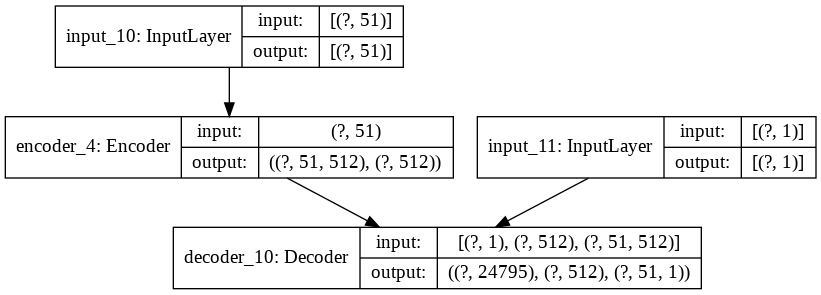

In [49]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
# encoder
enc_input = tf.keras.layers.Input(shape=(eng_maxlen, ))
encoder = Encoder(len(eng_token.word_index)+1, 512, 512)
encoder_output, encoder_hidden = encoder(enc_input)

# decoder
decoder_hidden_init = encoder_hidden
dec_input = tf.keras.layers.Input(shape=(1,))
decoder = Decoder(len(spa_token.word_index) + 1, 512, 512)
decoder_output, decoder_hidden, att_weight = decoder([dec_input, decoder_hidden_init, encoder_output])

In [0]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

def loss_function(real, pred):
  loss = loss_object(real, pred)
  return tf.reduce_mean(loss)


# @tf.function
# def train_step(input, target):
#   loss = 0

#   with tf.GradientTape() as tape:
#     enc_output, enc_hidden = encoder(enc_input)

#     dec_hidden = enc_hidden
#     dec_input = tf.expand_dims([spa_token.word_index['<start>']]*32, 1)

#     for timestep in range(1, target.shape[1]):
#       dec_prediction, dec_hidden, attention_weight = decoder([dec_input, dec_hidden, enc_output])
#       loss = loss + loss_function(target[:, timestep], dec_prediction)
#       dec_input = tf.expand_dims(target[:, t], 1)
  
#   variables = encoder.trainable_variables + decoder.trainable_variables
#   gradient = tape.gradient(loss, varibales)
#   optimizer.apply_gradients(zip(gradients, variables))
#   return loss


@tf.function
def train_step(inp, targ):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([spa_token.word_index['<start>']] * 32, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder([dec_input, dec_hidden, enc_output])

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((eng_sequence, spa_sequence))
dataset = dataset.batch(32)

In [0]:
EPOCH = 10

for epoch in range(EPOCH):

  total_loss = 0
  for (batch, (inp, target)) in enumerate(dataset):
    batch_loss = train_step(inp, target)
    total_loss += batch_loss
  
  print(f'epoch :{epoch+1}\tloss{total_loss}')